# ResNet

### ResidualBlock

In [23]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv_path = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels,
                      kernel_size=3, padding=1)
        )
        self.skip_path = nn.Identity()
        self.act = nn.ReLU()

    def forward(self, x):
        conv = self.conv_path(x)
        skip = self.skip_path(x)
        sum = conv + skip
        out = self.act(sum)
        return out

test_data = torch.randn((1, 3, 32, 32))
residual_block = ResidualBlock(in_channels=3, out_channels=3)
output = residual_block(test_data)
print(f"output shape : {output.shape}")

output shape : torch.Size([1, 3, 32, 32])


### ResidualBlockDown

In [24]:
import torch.nn as nn

class ResidualBlockDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlockDown, self).__init__()
        self.conv_path = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                      kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels,
                      kernel_size=3, padding=1)
        )
        self.conv2_path = nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels,
            kernel_size=1, stride=2
        )
        self.act = nn.ReLU()
    def forward(self, x):
        conv = self.conv_path(x)
        conv2 = self.conv2_path(x)
        sum = conv + conv2
        out = self.act(sum)
        return out

test_data = torch.randn((1, 3, 32, 32))
residual_block = ResidualBlockDown(in_channels=3, out_channels=3)
output = residual_block(test_data)
print(f"output shape : {output.shape}")

output shape : torch.Size([1, 3, 16, 16])


### ResNet34 Naive

In [25]:
import torch
import torch.nn as nn

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding=3, stride=2),
            nn.ReLU()
        )
        self.conv2_x = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=2),
            ResidualBlock(in_channels=64, out_channels=64),
            ResidualBlock(in_channels=64, out_channels=64),
            ResidualBlock(in_channels=64, out_channels=64)
        )
        self.conv3_x = nn.Sequential(
            ResidualBlockDown(in_channels=64, out_channels=128),
            ResidualBlock(in_channels=128, out_channels=128),
            ResidualBlock(in_channels=128, out_channels=128),
            ResidualBlock(in_channels=128, out_channels=128)
        )
        self.conv4_x = nn.Sequential(
            ResidualBlockDown(in_channels=128, out_channels=256),
            ResidualBlock(in_channels=256, out_channels=256),
            ResidualBlock(in_channels=256, out_channels=256),
            ResidualBlock(in_channels=256, out_channels=256),
            ResidualBlock(in_channels=256, out_channels=256),
            ResidualBlock(in_channels=256, out_channels=256)
        )
        self.conv5_x = nn.Sequential(
            ResidualBlockDown(in_channels=256, out_channels=512),
            ResidualBlock(in_channels=512, out_channels=512),
            ResidualBlock(in_channels=512, out_channels=512)
        )
        self.pool = nn.AvgPool2d(kernel_size=7)
        self.classifier = nn.Linear(in_features=512, out_features=1000)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        out = self.classifier(x)
        return out

shape = (8, 3, 224, 224)
test_data = torch.randn(shape)
model = ResNet()
output = model(test_data)
print(f"output shape : {output.shape}")

output shape : torch.Size([8, 1000])


### AdvancedResiducalBlock

In [29]:
import torch
import torch.nn as nn

class AdvancedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_down=False):
        super(AdvancedResidualBlock, self).__init__()

        if not is_down and in_channels != out_channels:
            raise ValueError("When it's not 'down', `in_channels` and `out_channels` should be the same.")

        self.in_channels, self.out_channels = in_channels, out_channels
        stride = 2 if is_down else 1

        self.conv_path = nn.Sequential(
            self._make_conv(stride=stride),
            nn.ReLU(),
            self._make_conv(is_second=True)
        )
        self.skip_path = self._make_conv(stride=stride) if is_down else nn.Identity()
        self.act = nn.ReLU()

    def forward(self, x):
        conv = self.conv_path(x)
        skip = self.skip_path(x)
        sum = conv + skip
        out = self.act(sum)
        return out

    def _make_conv(self, is_second=False, stride=1):
        in_channels = self.out_channels if is_second else self.in_channels
        conv = nn.Conv2d(in_channels=in_channels, out_channels=self.out_channels,
                         kernel_size=3, padding=1, stride=stride)
        return conv



data = torch.randn((1, 3, 32, 32))
residual_block = AdvancedResidualBlock(in_channels=3, out_channels=3)
output = residual_block(data)
print(f"output shape : {output.shape}")

residual_block = AdvancedResidualBlock(in_channels=3, out_channels=6, is_down=True)
output = residual_block(data)
print(f"down output shape : {output.shape}")

output shape : torch.Size([1, 3, 32, 32])
down output shape : torch.Size([1, 6, 16, 16])


### ResNet34

In [31]:
import torch
import torch.nn as nn

class ResNet34(nn.Module):
    def __init__(self):
        super(ResNet34, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding=3, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, padding=1, stride=2),
        )
        self.conv2_x = self._make_layers(in_channels=64, out_channels=64,
                                         n_blocks=3, downsmaple=False)
        self.conv3_x = self._make_layers(in_channels=64, out_channels=128,
                                         n_blocks=4, downsmaple=True)
        self.conv4_x = self._make_layers(in_channels=128, out_channels=256,
                                         n_blocks=6, downsmaple=True)
        self.conv5_x = self._make_layers(in_channels=256, out_channels=512,
                                         n_blocks=3, downsmaple=True)
        self.pool = nn.AvgPool2d(kernel_size=7)
        self.classifier = nn.Linear(in_features=512, out_features=1000)

    def _make_layers(self, in_channels, out_channels, n_blocks, downsample):

        blocks = []

        for _ in range(n_blocks):
            block = AdvancedResidualBlock(in_channels=in_channels, out_channels=out_channels, is_down=downsample)
            blocks.append(block)
            in_channels = out_channels
            downsample = False

        return nn.Sequential(*blocks)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        out = self.classifier(x)
        return out

shape = (8, 3, 224, 224)
test_data = torch.randn(shape)
model = ResNet()
output = model(test_data)
print(f"output shape : {output.shape}")

output shape : torch.Size([8, 1000])


### ResNet

In [49]:
import torch
import torch.nn as nn

class ResNet(nn.Module):
    def __init__(self, n_blocks_list):
        super(ResNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding=3, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, padding=1, stride=2),
        )
        self.conv2_x = self._make_layers(in_channels=64, out_channels=64,
                                         n_blocks=n_blocks_list[0], downsample=False)
        self.conv3_x = self._make_layers(in_channels=64, out_channels=128,
                                         n_blocks=n_blocks_list[1], downsample=True)
        self.conv4_x = self._make_layers(in_channels=128, out_channels=256,
                                         n_blocks=n_blocks_list[2], downsample=True)
        self.conv5_x = self._make_layers(in_channels=256, out_channels=512,
                                         n_blocks=n_blocks_list[3], downsample=True)
        self.pool = nn.AvgPool2d(kernel_size=7)
        self.classifier = nn.Linear(in_features=512, out_features=10000)

    def _make_layers(self, in_channels, out_channels, n_blocks, downsample):

        blocks = []

        for _ in range(n_blocks):
            block = AdvancedResidualBlock(in_channels=in_channels, out_channels=out_channels, is_down=downsample)
            blocks.append(block)
            in_channels = out_channels
            downsample = False

        return nn.Sequential(*blocks)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        out = self.classifier(x)
        return out

resNet32 = lambda : ResNet(n_blocks_list=[3, 4, 6, 3])

shape = (8, 3, 224, 224)
test_data = torch.randn(shape)
model = resNet32()
output = model(test_data)
print(f"output shape : {output.shape}")


output shape : torch.Size([8, 10000])


### CIFAR Learning

In [47]:
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import SGD

seed = 42
torch.manual_seed(seed)
BATCH_SIZE = 8
LR = 0.02
EPOCHS = 10
DEVICE = "cuda"

data = CIFAR10(root="data", train=True, download=True, transform=ToTensor())
n_data = len(data)
dataloader = DataLoader(dataset=data, batch_size=BATCH_SIZE)

model = ResNet(n_blocks_list=[3, 4, 6, 3])
model.to(DEVICE)
optimizer = SGD(model.parameters(), lr=LR)
loss_function = nn.CrossEntropyLoss()

epoch_losses, epoch_accs = [], []

for epoch in range(EPOCHS):
    epoch_loss, epoch_acc = 0., 0
    for X, Y in tqdm(dataloader, desc="진행중"):
        X, Y = X.to(DEVICE), Y.to(DEVICE)

        pred = model(X)

        loss = loss_function(pred, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * len(X)

        pred_max_indices = torch.argmax(pred, axis=1)
        corrects = torch.sum(pred_max_indices == Y)
        epoch_acc += corrects.cpu()

    epoch_losses.append(epoch_loss / n_data)
    epoch_accs.append(epoch_acc / n_data)

Files already downloaded and verified


진행중: 100%|██████████| 6250/6250 [01:37<00:00, 64.41it/s]


### visualization

Text(0.5, 0, 'Epoch')

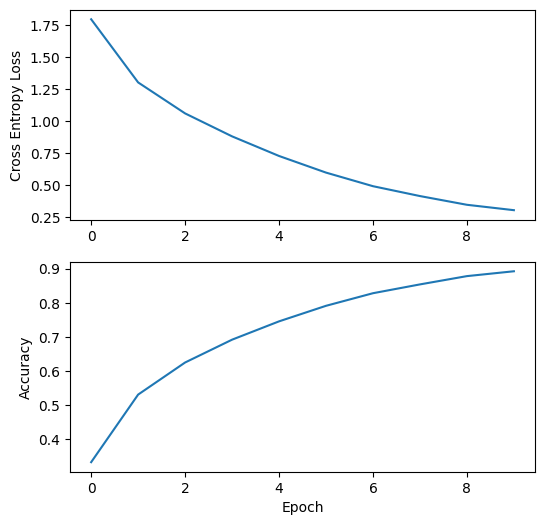

In [48]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))
axes[0].plot(range(len(epoch_losses)), epoch_losses)
axes[0].set_ylabel("Cross Entropy Loss")
axes[1].plot(range(len(epoch_accs)), epoch_accs)
axes[1].set_ylabel("Accuracy")
axes[1].set_xlabel("Epoch")